# OBJECTIF #

- Assembler 4 à 6 variables parlantes pour un président d'agglomération, le but étant que le président puisse ajuster ces variables pour simuler l'impact des poliques futures qu'il va mener.
    - Idéalement, il faudrait deux groupes de variables sur une variété d'axes : 
        - Des variables avec un impact négatif sur la pauvreté
        - Des variables avec un impact positif sur la pauvreté

    - Les axes qui semblent intéressants pour cet exercise sont :
        - Démographie
            - ratio population par ménage
        - emploi
            - Taux de chômage
        - logement
            - Taux de propriétaire principal
        - formation
            - Taux de non diplômés (15 ans ou plus)
        - entreprises
            - Taux impact local

- Les  variables doivent être corrélées à l'indicateur de pauvreté TP6020 pour une modélisation qui vise à prédire cette variable lorsque des paramètres sont ajustés.

Le dataset de ce notebook a été réduit aux données disponibles pour la variable TP6020.
Il ne contient aucun NaN et la nature des données n'a pas été transformée.
En l'état, et suite à une étude des corrélations précédemment effectuées, aucune corrélation importante n'a été trouvée mis à part la variable MED20 relative au revenu de vie médian.

Lien vers le dictionnaire des variables du dataset. Toutes les variables > 29K NaN, à l'exception de la TP6020, ont été supprimées : https://docs.google.com/spreadsheets/d/1DtyFTiprlnxWawDKxqjiR8y03np2ra3L6a9YIVuVnPQ/edit#gid=1496962940

## IMPORT DES LIBRAIRIES ##

In [1]:
import pandas as pd
import numpy as np

#élargissement de la visualisation des tableaux pandas
pd.set_option('display.max_columns', None)

#suppression des warnings
import warnings
warnings.filterwarnings('ignore')

#visualisations
import seaborn as sns
import matplotlib.pyplot as plt

#stats
from scipy.stats import pearsonr

#modélisation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn.pipeline import Pipeline


## IMPORT DU DATASET ##

In [2]:
df = pd.read_csv('../files/dataframe_complet.csv', dtype={'CODGEO': 'string', 'num_dep': 'string'})

In [3]:
df = df.drop(['Unnamed: 0', 
             'P19_RP_MIDUR', 
             'P19_RP_MIBOIS', 
             'P19_RP_CASE', 
             'P19_RP_HABFOR', 
             'P19_RP_TTEGOU', 
             'P19_RP_CLIM',
             'P19_RP_ELEC',
             'P19_RP_EAUCH',
             'P19_RP_BDWC',
              'P19_RP_CHOS',
              'TP60AGE620',
              'TP60AGE120',
              'TP60AGE520',
              'TP60AGE420',
              'TP60AGE220',
              'TP60AGE320',
              'TP60TOL120',
              'TP60TOL220'],axis=1)

In [4]:
df = df[df['TP6020'].isna() == False].reset_index(drop=True)
df = df.dropna().reset_index(drop=True)

In [5]:
df.head(3)

,CODGEO,EU_circo,num_region,num_dep,nom_commune,nom_dep,nom_region,num_chef_lieu,nom_chef_lieu,code_postal,latitude,longitude,pop_tot,SUPERF,P19_POP,P19_POP1529,P19_POP3044,P19_POP4559,P19_POP6074,P19_POP7589,P19_POP90P,P19_POPH,P19_H1529,P19_H3044,P19_H4559,P19_H6074,P19_H7589,P19_H90P,P19_H0019,P19_H2064,P19_H65P,P19_POPF,P19_F1529,P19_F3044,P19_F4559,P19_F6074,P19_F7589,P19_F90P,P19_F0019,P19_F2064,P19_F65P,P19_POP01P,P19_POP01P_IRAN1,P19_POP01P_IRAN2,P19_POP01P_IRAN3,P19_POP01P_IRAN4,P19_POP01P_IRAN5,P19_POP01P_IRAN6,P19_POP01P_IRAN7,P19_POP0114_IRAN2P,P19_POP0114_IRAN2,P19_POP0114_IRAN3P,P19_POP1524_IRAN2P,P19_POP1524_IRAN2,P19_POP1524_IRAN3P,P19_POP2554_IRAN2P,P19_POP2554_IRAN2,P19_POP2554_IRAN3P,P19_POP55P_IRAN2P,P19_POP55P_IRAN2,P19_POP55P_IRAN3P,C19_POP15P,C19_POP15P_CS1,C19_POP15P_CS2,C19_POP15P_CS3,C19_POP15P_CS4,C19_POP15P_CS5,C19_POP15P_CS6,C19_POP15P_CS7,C19_POP15P_CS8,C19_H15P,C19_H15P_CS1,C19_H15P_CS2,C19_H15P_CS3,C19_H15P_CS4,C19_H15P_CS5,C19_H15P_CS6,C19_H15P_CS7,C19_H15P_CS8,C19_F15P,C19_F15P_CS1,C19_F15P_CS2,C19_F15P_CS3,C19_F15P_CS4,C19_F15P_CS5,C19_F15P_CS6,C19_F15P_CS7,C19_F15P_CS8,C19_POP1524,C19_POP1524_CS1,C19_POP1524_CS2,C19_POP1524_CS3,C19_POP1524_CS4,C19_POP1524_CS5,C19_POP1524_CS6,C19_POP1524_CS7,C19_POP1524_CS8,C19_POP2554,C19_POP2554_CS1,C19_POP2554_CS2,C19_POP2554_CS3,C19_POP2554_CS4,C19_POP2554_CS5,C19_POP2554_CS6,C19_POP2554_CS7,C19_POP2554_CS8,C19_POP55P,C19_POP55P_CS1,C19_POP55P_CS2,C19_POP55P_CS3,C19_POP55P_CS4,C19_POP55P_CS5,C19_POP55P_CS6,C19_POP55P_CS7,C19_POP55P_CS8,C19_MEN,C19_MENPSEUL,C19_MENHSEUL,C19_MENFSEUL,C19_MENSFAM,C19_MENFAM,C19_MENCOUPSENF,C19_MENCOUPAENF,C19_MENFAMMONO,C19_PMEN,C19_PMEN_MENPSEUL,C19_PMEN_MENHSEUL,C19_PMEN_MENFSEUL,C19_PMEN_MENSFAM,C19_PMEN_MENFAM,C19_PMEN_MENCOUPSENF,C19_PMEN_MENCOUPAENF,C19_PMEN_MENFAMMONO,P19_POP15P,P19_POP1519,P19_POP2024,P19_POP2539,P19_POP4054,P19_POP5564,P19_POP6579,P19_POP80P,P19_POPMEN1519,P19_POPMEN2024,P19_POPMEN2539,P19_POPMEN4054,P19_POPMEN5564,P19_POPMEN6579,P19_POPMEN80P,P19_POP1519_PSEUL,P19_POP2024_PSEUL,P19_POP2539_PSEUL,P19_POP4054_PSEUL,P19_POP5564_PSEUL,P19_POP6579_PSEUL,P19_POP80P_PSEUL,P19_POP1519_COUPLE,P19_POP2024_COUPLE,P19_POP2539_COUPLE,P19_POP4054_COUPLE,P19_POP5564_COUPLE,P19_POP6579_COUPLE,P19_POP80P_COUPLE,P19_POP15P_MARIEE,P19_POP15P_PACSEE,P19_POP15P_CONCUB_UNION_LIBRE,P19_POP15P_VEUFS,P19_POP15P_DIVORCEE,P19_POP15P_CELIBATAIRE,C19_MEN_CS1,C19_MEN_CS2,C19_MEN_CS3,C19_MEN_CS4,C19_MEN_CS5,C19_MEN_CS6,C19_MEN_CS7,C19_MEN_CS8,C19_PMEN_CS1,C19_PMEN_CS2,C19_PMEN_CS3,C19_PMEN_CS4,C19_PMEN_CS5,C19_PMEN_CS6,C19_PMEN_CS7,C19_PMEN_CS8,C19_FAM,C19_COUPAENF,C19_FAMMONO,C19_HMONO,C19_FMONO,C19_COUPSENF,C19_NE24F0,C19_NE24F1,C19_NE24F2,C19_NE24F3,C19_NE24F4P,P19_LOG,P19_RP,P19_RSECOCC,P19_LOGVAC,P19_MAISON,P19_APPART,P19_RP_1P,P19_RP_2P,P19_RP_3P,P19_RP_4P,P19_RP_5PP,P19_NBPI_RP,P19_RPMAISON,P19_NBPI_RPMAISON,P19_RPAPPART,P19_NBPI_RPAPPART,C19_RP_HSTU1P,C19_RP_HSTU1P_SUROCC,P19_RP_ACHTOT,P19_RP_ACH19,P19_RP_ACH45,P19_RP_ACH70,P19_RP_ACH90,P19_RP_ACH05,P19_RPMAISON_ACH19,P19_RPMAISON_ACH45,P19_RPMAISON_ACH70,P19_RPMAISON_ACH90,P19_RPMAISON_ACH05,P19_RPAPPART_ACH19,P19_RPAPPART_ACH45,P19_RPAPPART_ACH70,P19_RPAPPART_ACH90,P19_RPAPPART_ACH05,P19_MEN,P19_MEN_ANEM0002,P19_MEN_ANEM0204,P19_MEN_ANEM0509,P19_MEN_ANEM10P,P19_MEN_ANEM1019,P19_MEN_ANEM2029,P19_MEN_ANEM30P,P19_PMEN,P19_PMEN_ANEM0002,P19_PMEN_ANEM0204,P19_PMEN_ANEM0509,P19_PMEN_ANEM10P,P19_NBPI_RP_ANEM0002,P19_NBPI_RP_ANEM0204,P19_NBPI_RP_ANEM0509,P19_NBPI_RP_ANEM10P,P19_RP_PROP,P19_RP_LOC,P19_RP_LOCHLMV,P19_RP_GRAT,P19_NPER_RP,P19_NPER_RP_PROP,P19_NPER_RP_LOC,P19_NPER_RP_LOCHLMV,P19_NPER_RP_GRAT,P19_ANEM_RP,P19_ANEM_RP_PROP,P19_ANEM_RP_LOC,P19_ANEM_RP_LOCHLMV,P19_ANEM_RP_GRAT,P19_RP_SDB,P19_RP_CCCOLL,P19_RP_CCIND,P19_RP_CINDELEC,P19_RP_GARL,P19_RP_VOIT1P,P19_RP_VOIT1,P19_RP_VOIT2P,P19_POP0205,P19_POP0610,P19_POP1824,P19_POP2529,P19_POP30P,P19_SCOL0205,P19_SCOL0610,P19_SCOL1824,P19_SCOL2529,P19_SCOL30P,P19_H0205,P19_H0610,P19_H1824,P19_H2529,P19_H30P,P19_HSCOL0205,P19_H

In [6]:
df.shape

(4249, 719)

### Démographique ###

In [7]:
P19_PMEN = np.array(df.P19_PMEN)#Pop ménages en 2019 (princ)
P19_MEN = np.array(df.P19_MEN)#Ménages en 2019 (princ)
ratio_pop_par_menage = np.array(np.round(P19_PMEN / P19_MEN,2))

pd.DataFrame({'P19_PMEN': P19_PMEN[0:5], 'P19_MEN': P19_MEN[0:5], 'ratio_pop_par_menage': ratio_pop_par_menage[0:5]})

,P19_PMEN,P19_MEN,ratio_pop_par_menage
0,13625.012669,6606.346575,2.06
1,2790.000000,1169.000000,2.39
2,3306.001851,1363.663244,2.42
3,4030.000000,1597.000000,2.52
4,3627.997137,1681.266230,2.16


### Chomage ###

Calcul du taux de chômage 2019 des 15 à 64 ans

In [8]:
P19_ACT1564 = np.array(df.P19_ACT1564) #Population active de 15 à 64 ans
P19_CHOMEUR1564 = np.array(df.P19_CHOMEUR1564) #Population de chômeurs de 15 à 64 ans
Taux_chomage = np.array(np.round(P19_CHOMEUR1564 / P19_ACT1564 * 100,2)) #Taux de chômage en 2019

P19_POP = np.array(df.P19_POP)
P19_CHOM_DIPLMIN = np.array(df.P19_CHOM_DIPLMIN) #Chômeurs Sans diplôme ou CEP en 2019 (princ)
Taux_chomage_sans_diplome = np.array(np.round(P19_CHOM_DIPLMIN / P19_POP * 100,2))

### Logement ###

In [9]:
P19_NPER_RP = np.array(df.P19_NPER_RP) #Personnes Rés princ en 2019 (princ)
P19_NPER_RP_PROP = np.array(df.P19_NPER_RP_PROP) #Pers Rés princ occupées Propriétaires en 2019 (princ)
taux_proprietaire_princ = np.array(np.round(P19_NPER_RP_PROP / P19_NPER_RP * 100,2))

P19_RP = np.array(df.P19_RP) #Résidences principales en 2019 (princ)
P19_RPMAISON = np.array(df.P19_RPMAISON) #Rés princ type maison en 2019 (princ)
taux_maison_princ = np.array(np.round(P19_RPMAISON / P19_RP * 100,2))

P19_LOG = np.array(df.P19_LOG) #Nombre de logements en 2019
P19_MAISON = np.array(df.P19_MAISON) #Nombre de maisons en 2019
Taux_maisons = np.array(np.round(P19_MAISON / P19_LOG * 100,2)) #Taux de maisons en 2019

C19_MEN = np.array(df.C19_MEN) #Ménages en 2019 (compl)
C19_MENFSEUL = np.array(df.C19_MENFSEUL) #"Ménages femmes seules en 2019 (compl)"
Taux_femme_seule = np.array(np.round(C19_MENFSEUL / C19_MEN * 100,2))

### Entreprises ###

In [10]:
ETTOT20 = np.array(df.ETTOT20) #Nombre total d'entreprises
ETBE20 = np.array(df.ETBE20) #Ets actifs industrie fin 2020
Taux_industrie = np.array(np.round(ETBE20 / ETTOT20 * 100,2))
commune_industrielle = [1 if i > 20 else 0 for i in Taux_industrie]

ETTOT20 = np.array(df.ETTOT20) #Nombre total d'entreprises
ETPRES20 = np.array(df.ETPRES20) #Nombre d'établissements actifs avec une sphère présentielle
Taux_impact_ets_local = np.array(np.round(ETPRES20 / ETTOT20 * 100,2)) #Taux d'impact local des établissements en 2020 
plus_de_10_ets = [1 if i >= 10 else 0 for i in ETTOT20 ]


C19_MEN_CS2 = np.array(df.C19_MEN_CS2) #Ménages Pers Réf Art. Comm. Chefs entr. en 2019 (compl)
C19_MEN_CS3 = np.array(df.C19_MEN_CS3) #Ménages Pers Réf Cadres Prof int sup en 2019 (compl)

C19_MEN = np.array(df.C19_MEN) #Ménages en 2019 (compl)
taux_menage_dirigeant = np.array(np.round(C19_MEN_CS2 / C19_MEN * 100,2))
taux_menage_CSP_plus = np.array(np.round(C19_MEN_CS3 / C19_MEN * 100,2))


ETPTOT20 = np.array(df.ETPTOT20) #Postes des Ets actifs fin 2020
ETTOT20 = np.array(df.ETTOT20) #Nombre total d'entreprises
nb_salarie_moyen_par_ets = np.array(np.round(ETPTOT20 / ETTOT20 * 100,2))

ETTOT20 = np.array(df.ETTOT20) #Total Ets actifs fin 2020
ETCTOT20 = np.array(df.ETCTOT20) #Créations d'ets en 2020
taux_crea = np.array(np.round(ETCTOT20 / ETTOT20 * 100,2))


ENCTOT19 = np.array(df.ENCTOT19) #Créations d'entr. en 2019
ENCITOT19 = np.array(df.ENCITOT19) #Créations d'entr. ind. en 2019
taux_crea_ind = np.array(np.round(ENCITOT19 / ENCTOT19 * 100,2))


ETPTOT20 = np.array(df.ETPTOT20) #Postes des Ets actifs fin 2020
ETPBE20 = np.array(df.ETPBE20)#Postes des Ets actifs de l'industrie fin 2020
taux_postes_ind = np.array(np.round(ETPBE20 / ETPTOT20 * 100,2))

pop_tot = np.array(df.pop_tot)
ETTOT20 = np.array(df.ETTOT20)
ratio_ets_pop = np.array(np.round(ETTOT20 / pop_tot * 100,2))

In [11]:
pd.DataFrame({'ETTOT20': ETTOT20[0:5], 'ETBE20': ETBE20[0:5], 'commune_industrielle': commune_industrielle[0:5]})

,ETTOT20,ETBE20,commune_industrielle
0,586.0,31.0,0
1,68.0,11.0,0
2,229.0,53.0,1
3,60.0,7.0,0
4,161.0,46.0,1


### Formation ###

In [12]:
C19_F15P = np.array(df.C19_F15P) #Pop 15 ans ou plus Femmes en 2019 (compl)
P19_FNSCOL15P_DIPLMIN = np.array(df.P19_FNSCOL15P_DIPLMIN) #Femmes 15 ans ou plus non scol. Sans diplôme ou CEP en 2019 (princ)
taux_femmes_sans_diplome = np.array(np.round(P19_FNSCOL15P_DIPLMIN / C19_F15P * 100,2))

P19_POP15P = np.array(df.P19_POP15P)#Pop 15 ans ou plus en 2019 (princ)
P19_NSCOL15P_DIPLMIN = np.array(df.P19_NSCOL15P_DIPLMIN) #Pop 15 ans ou plus non scol. Sans diplôme ou CEP en 2019 (princ)
taux_sans_diplome = np.array(np.round(P19_NSCOL15P_DIPLMIN / P19_POP15P * 100,2)) #Taux de non diplômés (15 ans ou plus)


P19_POP1824 = np.array(df.P19_POP1824) #Pop 18 à 24 ans en 2019 (compl)
P19_SCOL1824 = np.array(df.P19_SCOL1824) #Pop 18 à 24 ans scolarisée en 2019 (princ)
taux_scolarisation_1824 = np.array(np.round(P19_SCOL1824 / P19_POP1824 * 100,2)) #Taux de descolarisation des 15 à 24 ans en 2019

P19_F0610 = np.array(df.P19_F0610) #Femmes 6-10 ans en 2019 (princ)
P19_FSCOL0610 = np.array(df.P19_FSCOL0610) #Femmes scolarisées 6-10 ans en 2019 (princ)
Taux_scolarisation_femme6_10 = np.array(np.round(P19_FSCOL0610 / P19_F0610 * 100,2))


In [13]:
pd.DataFrame({'P19_F0610': P19_F0610[0:5], 'P19_FSCOL0610': P19_FSCOL0610[0:5]})

,P19_F0610,P19_FSCOL0610
0,416.892744,407.049395
1,113.000000,113.000000
2,121.827321,117.936299
3,150.000000,144.000000
4,136.866748,131.805421


# DATASET POUR ML #

In [14]:
data = pd.DataFrame({'CODGEO': df.CODGEO, 
                     'Taux_chomage': Taux_chomage,  
                     #'taux_proprietaire_princ': taux_proprietaire_princ,
                     #'Taux_impact_ets_local': Taux_impact_ets_local,
                     'taux_sans_diplome': taux_sans_diplome,
                     'Taux_chomage_sans_diplome': Taux_chomage_sans_diplome,
                     #'ratio_pop_par_menage': ratio_pop_par_menage,
                     'part_presta_logement': df.PPLOGT20, #parr des presta logement dans les presta sociales
                     #'ratio_ets_pop': ratio_ets_pop,
                     #'commune_industrielle': commune_industrielle,
                     #'taux_postes_ind': taux_postes_ind,
                     #'Taux_scolarisation_femme6_10': Taux_scolarisation_femme6_10,
                     #'taux_crea_ind': taux_crea_ind,
                     #'taux_maison_princ': taux_maison_princ,
                     #'Taux_femme_seule': Taux_femme_seule,
                     #'taux_crea': taux_crea,
                     #'taux_menage_CSP_plus': taux_menage_CSP_plus,
                     #'taux_femmes_sans_diplome': taux_femmes_sans_diplome,
                     #'taux_scolarisation_1824': taux_scolarisation_1824,
                     'TP6020': df.TP6020,
                    })

data.head(20)

,CODGEO,Taux_chomage,taux_sans_diplome,Taux_chomage_sans_diplome,part_presta_logement,TP6020
0,01004,14.77,19.36,1.54,1.7,17.0
1,01007,7.61,13.33,0.57,0.8,7.0
2,01014,13.98,32.39,2.00,0.9,10.0
3,01025,7.14,18.07,0.66,0.6,6.0
4,01031,14.99,31.01,2.62,1.6,19.0
5,01032,8.57,15.10,0.81,0.8,9.0
6,01033,15.37,24.82,1.62,1.1,16.0
7,01034,16.42,25.73,1.90,1.6,18.0
8,01043,6.72,11.57,0.46,0.5,5.0
9,01053,17.93,22.18,1.89,2.1,22.0


In [15]:
data.describe()

,Taux_chomage,taux_sans_diplome,Taux_chomage_sans_diplome,part_presta_logement,TP6020
count,4249.000000,4249.000000,4249.000000,4249.000000,4249.000000
mean,13.082904,20.756889,1.126583,1.234502,13.174629
std,4.675677,6.645875,0.691612,0.712054,6.105253
min,1.830000,5.220000,0.050000,0.200000,5.000000
25%,9.620000,15.790000,0.610000,0.700000,9.000000
50%,12.120000,20.170000,0.960000,1.000000,12.000000
75%,15.580000,25.150000,1.480000,1.600000,16.000000
max,40.210000,46.260000,4.930000,5.700000,46.000000


# ANALYSE DES CORRELATIONS #

<Axes: >

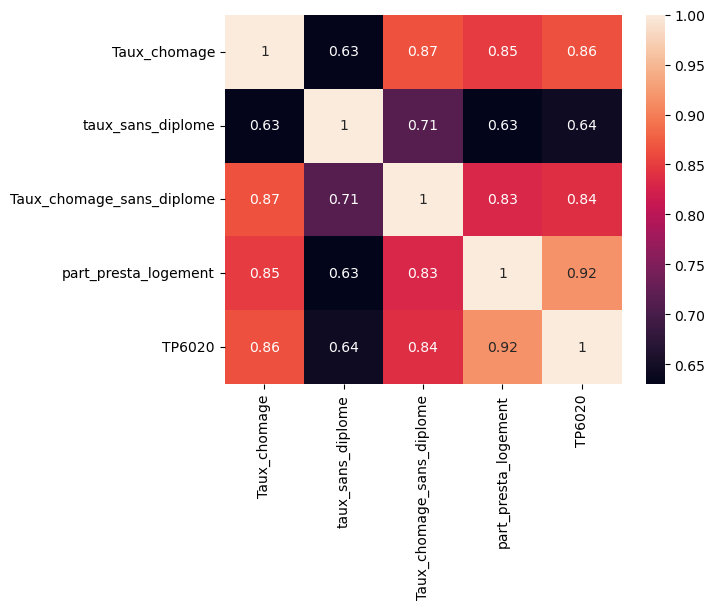

In [16]:
sns.heatmap(data.corr(), annot=True)

# MODELISATION #

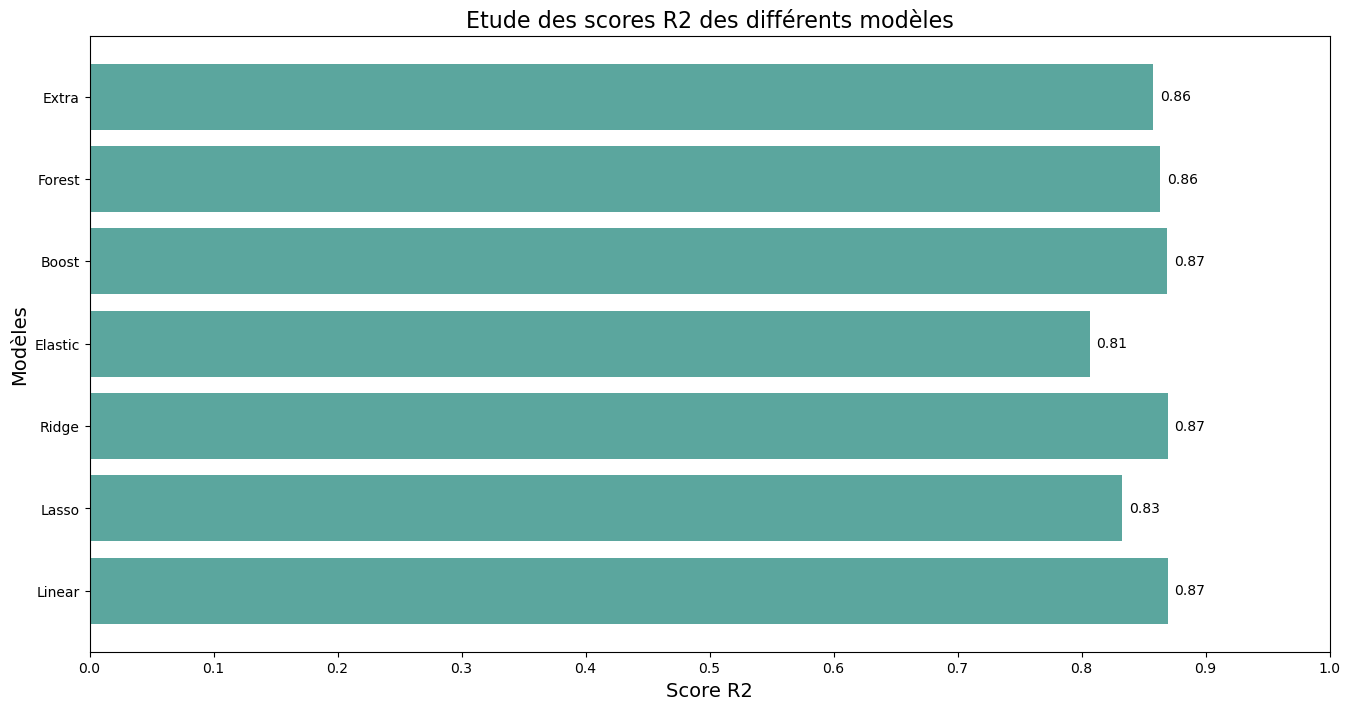

In [17]:
X = data.drop(['CODGEO', 'TP6020'], axis=1)
y = data.TP6020

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()

models = [linear_model.LinearRegression(),
         linear_model.Lasso(),
         linear_model.Ridge(),
         linear_model.ElasticNet(),
         ensemble.GradientBoostingRegressor(),
         ensemble.RandomForestRegressor(),
         ensemble.ExtraTreesRegressor()]

model_names = ['Linear', 'Lasso', 'Ridge', 'Elastic', 'Boost', 'Forest', 'Extra']

scores = []
mse = []
mae = []
y_predicts = []

for model in models:
    pipe = Pipeline(steps=[('normalize', scaler),('model', model)])
    fits = pipe.fit(X_train, y_train)
    scores.append(metrics.r2_score(y_test, fits.predict(X_test)))
    mse.append(metrics.mean_squared_error(y_test, fits.predict(X_test)))
    mae.append(metrics.median_absolute_error(y_test, fits.predict(X_test)))
    y_predicts.append(pipe.predict(X_test))

fig, ax = plt.subplots(1,1, figsize=(16,8))
barh = ax.barh(model_names, scores, color='#5BA69E')
labels = [np.round(i,2) for i in barh.datavalues]
ax.bar_label(barh, labels=labels, padding=5)
ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_xlabel('Score R2', fontsize=14)
ax.set_ylabel('Modèles', fontsize=14)
ax.set_title('Etude des scores R2 des différents modèles', fontsize=16)
plt.show()

In [18]:
for i in range(0, np.size(model_names) -1):
    print('10 premières lignes de '+model_names[i])
    display(pd.DataFrame({'y_true': y_test, 'y_predict': y_predicts[i]}).head(10))

10 premières lignes de Linear


,y_true,y_predict
2269,19.0,15.771257
1192,20.0,20.622599
2623,13.0,13.909143
3048,15.0,14.499723
120,10.0,11.853205
2572,12.0,14.579854
1454,6.0,8.704786
4045,9.0,7.677280
2970,8.0,8.550336
561,16.0,14.192873


10 premières lignes de Lasso


,y_true,y_predict
2269,19.0,15.024544
1192,20.0,19.296823
2623,13.0,13.741051
3048,15.0,14.240650
120,10.0,12.118072
2572,12.0,14.164824
1454,6.0,9.594247
4045,9.0,8.870312
2970,8.0,9.610919
561,16.0,13.950518


10 premières lignes de Ridge


,y_true,y_predict
2269,19.0,15.773131
1192,20.0,20.622331
2623,13.0,13.909415
3048,15.0,14.499741
120,10.0,11.853346
2572,12.0,14.581831
1454,6.0,8.704945
4045,9.0,7.677650
2970,8.0,8.550195
561,16.0,14.194343


10 premières lignes de Elastic


,y_true,y_predict
2269,19.0,15.945470
1192,20.0,19.023928
2623,13.0,13.867295
3048,15.0,14.264671
120,10.0,12.120544
2572,12.0,14.963591
1454,6.0,9.608744
4045,9.0,8.780338
2970,8.0,9.304894
561,16.0,14.452599


10 premières lignes de Boost


,y_true,y_predict
2269,19.0,15.019871
1192,20.0,21.231047
2623,13.0,14.149903
3048,15.0,14.532514
120,10.0,12.609630
2572,12.0,14.692116
1454,6.0,8.247127
4045,9.0,6.789264
2970,8.0,8.296997
561,16.0,13.743502


10 premières lignes de Forest


,y_true,y_predict
2269,19.0,13.95
1192,20.0,21.79
2623,13.0,15.06
3048,15.0,16.42
120,10.0,12.98
2572,12.0,14.70
1454,6.0,8.66
4045,9.0,7.19
2970,8.0,7.95
561,16.0,13.14
